# Performance Models and Impact with Compression of Job-Data with DBSCAN-Clustering

In [1]:
import sys
sys.path.insert(0, '..')
import collections

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from IPython.display import display, HTML
from ipywidgets import IntProgress

from RuntimePrediction.Predict import Predictor as C3OPredictor
from RuntimePrediction.DefaultModels import (GradientBoosting as GB,
                                             ErnestModel as EM)
from RuntimePrediction.CustomModels import (BasicOptimisticModel as BOM,
                                            OptimisticGradientBoosting as OGB)
from sklearn.cluster import DBSCAN

## Extract Runtime Data

In [2]:
kmeans_df = pd.read_csv('../data/kmeans.tsv')
sort_df = pd.read_csv('../data/sort.tsv')
grep_df = pd.read_csv('../data/grep.tsv')
sgd_df = pd.read_csv('../data/sgd.tsv')
pagerank_df = pd.read_csv('../data/pagerank.tsv')

## 1. Compression: Filter and remove duplicate datapoints

In [3]:
kmeans_compression_0 = kmeans_df.shape[0]
sort_compression_0 = sort_df.shape[0]
grep_compression_0 = grep_df.shape[0]
sgd_compression_0 = sgd_df.shape[0]
pagerank_compression_0 = pagerank_df.shape[0]

kmeans_df.drop_duplicates(inplace=True)
sort_df.drop_duplicates(inplace=True)
grep_df.drop_duplicates(inplace=True)
sgd_df.drop_duplicates(inplace=True)
pagerank_df.drop_duplicates(inplace=True)

kmeans_df.to_csv('../data/reduced-kmeans_1.tsv', index=False)
sort_df.to_csv('../data/reduced-sort_1.tsv', index=False)
grep_df.to_csv('../data/reduced-grep_1.tsv', index=False)
sgd_df.to_csv('../data/reduced-sgd_1.tsv', index=False)
pagerank_df.to_csv('../data/reduced-pagerank_1.tsv', index=False)

kmeans_compression_1 = round(1 - (kmeans_df.shape[0])/kmeans_compression_0, 4)
sort_compression_1 = round(1 - (sort_df.shape[0])/sort_compression_0, 4)
grep_compression_1 = round(1 - (grep_df.shape[0])/grep_compression_0, 4)
sgd_compression_1 = round(1 - (sgd_df.shape[0])/sgd_compression_0, 4)
pagerank_compression_1 = round(1 - (pagerank_df.shape[0])/pagerank_compression_0, 4)

kmeans_dp = kmeans_df.shape[0]
sort_dp = sort_df.shape[0]
grep_dp = grep_df.shape[0]
sgd_dp = sgd_df.shape[0]
pagerank_dp = pagerank_df.shape[0]

print("KMeans: First Compression: " + str(kmeans_compression_1) + " Datapoints: " + str(kmeans_df.shape[0]))
print("Sort: First Compression: " + str(sort_compression_1) + " Datapoints: " + str(sort_df.shape[0]))
print("Grep: First Compression: " + str(grep_compression_1) + " Datapoints: " + str(grep_df.shape[0]))
print("Sgd: First Compression: " + str(sgd_compression_1) + " Datapoints: " + str(sgd_df.shape[0]))
print("Pagerank: First Compression: " + str(pagerank_compression_1) + " Datapoints: " + str(pagerank_df.shape[0]))

KMeans: First Compression: 0.2733 Datapoints: 654
Sort: First Compression: 0.2873 Datapoints: 449
Grep: First Compression: 0.358 Datapoints: 520
Sgd: First Compression: 0.4578 Datapoints: 488
Pagerank: First Compression: 0.1631 Datapoints: 1180


## DBSCAN Clustering

In [18]:
# Ignore feature machine_type
kmeans_machine_type_column= pd.read_csv('../data/reduced-kmeans_1.tsv', sep='\t', usecols=range(1,2))
sort_machine_type_column= pd.read_csv('../data/reduced-sort_1.tsv', sep='\t', usecols=range(1,2))
grep_machine_type_column= pd.read_csv('../data/reduced-grep_1.tsv', sep='\t', usecols=range(1,2))
sgd_machine_type_column= pd.read_csv('../data/reduced-sgd_1.tsv', sep='\t', usecols=range(1,2))
pagerank_machine_type_column= pd.read_csv('../data/reduced-pagerank_1.tsv', sep='\t', usecols=range(1,2))

kmeans_headers = [*pd.read_csv('../data/reduced-kmeans_1.tsv', sep='\t', nrows=1)]
reducedKmeans = pd.read_csv('../data/reduced-kmeans_1.tsv', sep='\t', usecols=[c for c in kmeans_headers if c != 'machine_type'])

sort_headers = [*pd.read_csv('../data/reduced-sort_1.tsv', sep='\t', nrows=1)]
reducedSort = pd.read_csv('../data/reduced-sort_1.tsv', sep='\t', usecols=[c for c in sort_headers if c != 'machine_type'])

grep_headers = [*pd.read_csv('../data/reduced-grep_1.tsv', sep='\t', nrows=1)]
reducedGrep = pd.read_csv('../data/reduced-grep_1.tsv', sep='\t', usecols=[c for c in grep_headers if c != 'machine_type'])

sgd_headers = [*pd.read_csv('../data/reduced-sgd_1.tsv', sep='\t', nrows=1)]
reducedSgd = pd.read_csv('../data/reduced-sgd_1.tsv', sep='\t', usecols=[c for c in sgd_headers if c != 'machine_type'])

pagerank_headers = [*pd.read_csv('../data/reduced-pagerank_1.tsv', sep='\t', nrows=1)]
reducedPagerank = pd.read_csv('../data/reduced-pagerank_1.tsv', sep='\t', usecols=[c for c in pagerank_headers if c != 'machine_type'])

# Create Clusters with DBSCAN / set min_samples=2,3,4..
db_kmeans = DBSCAN(eps=5, algorithm='kd_tree', min_samples=2).fit(reducedKmeans)
db_sort = DBSCAN(eps=5, algorithm='kd_tree', min_samples=2).fit(reducedSort)
db_grep = DBSCAN(eps=5, algorithm='kd_tree', min_samples=2).fit(reducedGrep)
db_sgd = DBSCAN(eps=5, algorithm='kd_tree', min_samples=2).fit(reducedSgd)
db_pagerank = DBSCAN(eps=5, algorithm='kd_tree', min_samples=2).fit(reducedPagerank)

# get number of Clusters of every dataset
n_clusters_km = len(set(db_kmeans.labels_)) - (1 if -1 in db_kmeans.labels_ else 0)
n_clusters_sort = len(set(db_sort.labels_)) - (1 if -1 in db_sort.labels_ else 0)
n_clusters_grep = len(set(db_grep.labels_)) - (1 if -1 in db_grep.labels_ else 0)
n_clusters_sgd = len(set(db_sgd.labels_)) - (1 if -1 in db_sgd.labels_ else 0)
n_clusters_pr = len(set(db_pagerank.labels_)) - (1 if -1 in db_pagerank.labels_ else 0)

n_noise_km = list(db_kmeans.labels_).count(-1)
n_noise_sort = list(db_sort.labels_).count(-1)
n_noise_grep = list(db_grep.labels_).count(-1)
n_noise_sgd = list(db_sgd.labels_).count(-1)
n_noise_pr = list(db_pagerank.labels_).count(-1)

cluster_map_km = pd.DataFrame()
cluster_map_km['gross_runtime'] = reducedKmeans['gross_runtime']
cluster_map_km['cluster'] = db_kmeans.labels_

cluster_map_sort = pd.DataFrame()
cluster_map_sort['gross_runtime'] = reducedSort['gross_runtime']
cluster_map_sort['cluster'] = db_sort.labels_

cluster_map_grep = pd.DataFrame()
cluster_map_grep['gross_runtime'] = reducedGrep['gross_runtime']
cluster_map_grep['cluster'] = db_grep.labels_

cluster_map_sgd = pd.DataFrame()
cluster_map_sgd['gross_runtime'] = reducedSgd['gross_runtime']
cluster_map_sgd['cluster'] = db_sgd.labels_

cluster_map_pr = pd.DataFrame()
cluster_map_pr['gross_runtime'] = reducedPagerank['gross_runtime']
cluster_map_pr['cluster'] = db_pagerank.labels_

sorted_km = cluster_map_km.sort_values('cluster', ascending=True)
sorted_sort = cluster_map_sort.sort_values('cluster', ascending=True)
sorted_grep = cluster_map_grep.sort_values('cluster', ascending=True)
sorted_sgd = cluster_map_sgd.sort_values('cluster', ascending=True)
sorted_pr = cluster_map_pr.sort_values('cluster', ascending=True)

In [703]:
# put the feature machine_type back
kmeans_headers = [*pd.read_csv('../data/reduced-kmeans_1.tsv', sep='\t', nrows=1)]
reducedKmeans = pd.read_csv('../data/reduced-kmeans_1.tsv', sep='\t')

sort_headers = [*pd.read_csv('../data/reduced-sort_1.tsv', sep='\t', nrows=1)]
reducedSort = pd.read_csv('../data/reduced-sort_1.tsv', sep='\t')

grep_headers = [*pd.read_csv('../data/reduced-grep_1.tsv', sep='\t', nrows=1)]
reducedGrep = pd.read_csv('../data/reduced-grep_1.tsv', sep='\t')

sgd_headers = [*pd.read_csv('../data/reduced-sgd_1.tsv', sep='\t', nrows=1)]
reducedSgd = pd.read_csv('../data/reduced-sgd_1.tsv', sep='\t')

pagerank_headers = [*pd.read_csv('../data/reduced-pagerank_1.tsv', sep='\t', nrows=1)]
reducedPagerank = pd.read_csv('../data/reduced-pagerank_1.tsv', sep='\t')

In [704]:
# get centroids of all clusters
def get_centroid(cluster):
    cluster_ary = np.asarray(cluster)
    centroid = cluster_ary.mean(axis = 0)
    return int(centroid)

final_data_kmeans = pd.DataFrame()
final_data_sort = pd.DataFrame()
final_data_grep = pd.DataFrame()
final_data_sgd = pd.DataFrame()
final_data_pagerank = pd.DataFrame()

# KMEANS
for i in range(n_clusters_km):
    for c in sorted_km.loc[sorted_km['cluster'] == i].index:
        centroid_of_cluster_km = np.mean(get_centroid(sorted_km.loc[sorted_km['cluster'] == i].index))
        final_data_kmeans = final_data_kmeans.append(reducedKmeans.iloc[[int(centroid_of_cluster_km)] ,])
# put the noise data        
#for k in sorted_km.loc[sorted_km['cluster'] == -1].index:
#    final_data_kmeans = final_data_kmeans.append(reducedKmeans.iloc[[k] ,])

# SORT
for i in range(n_clusters_sort):
    for c in sorted_sort.loc[sorted_sort['cluster'] == i].index:
        centroid_of_cluster_sort = np.mean(get_centroid(sorted_sort.loc[sorted_sort['cluster'] == i].index))
        final_data_sort = final_data_sort.append(reducedSort.iloc[[int(centroid_of_cluster_sort)] ,])   

# GREP
for i in range(n_clusters_grep):
    for c in sorted_grep.loc[sorted_grep['cluster'] == i].index:
        centroid_of_cluster_grep = np.mean(get_centroid(sorted_grep.loc[sorted_grep['cluster'] == i].index))
        final_data_grep = final_data_grep.append(reducedGrep.iloc[[int(centroid_of_cluster_grep)] ,])

# SGD
for i in range(n_clusters_sgd):
    for c in sorted_sgd.loc[sorted_sgd['cluster'] == i].index:
        centroid_of_cluster_sgd = np.mean(get_centroid(sorted_sgd.loc[sorted_sgd['cluster'] == i].index))
        final_data_sgd = final_data_sgd.append(reducedSgd.iloc[[int(centroid_of_cluster_sgd)] ,])

# PAGERANK
for i in range(n_clusters_pr):
    for c in sorted_pr.loc[sorted_pr['cluster'] == i].index:
        centroid_of_cluster_pr = np.mean(get_centroid(sorted_pr.loc[sorted_pr['cluster'] == i].index))
        final_data_pagerank = final_data_pagerank.append(reducedPagerank.iloc[[int(centroid_of_cluster_pr)] ,])

final_data_kmeans.drop_duplicates(inplace=True)
final_data_sort.drop_duplicates(inplace=True)
final_data_grep.drop_duplicates(inplace=True)
final_data_sgd.drop_duplicates(inplace=True)
final_data_pagerank.drop_duplicates(inplace=True)

# Final data
final_data_kmeans.to_csv('../data/dbscan/reduced-kmeans_2.tsv', sep='\t', index=False)
final_data_sort.to_csv('../data/dbscan/reduced-sort_2.tsv', sep='\t', index=False)
final_data_grep.to_csv('../data/dbscan/reduced-grep_2.tsv', sep='\t', index=False)
final_data_sgd.to_csv('../data/dbscan/reduced-sgd_2.tsv', sep='\t', index=False)
final_data_pagerank.to_csv('../data/dbscan/reduced-pagerank_2.tsv', sep='\t', index=False)

## Define Models

In [44]:
Model = collections.namedtuple('Model', ['name', 'predictor', 'kwargs'])

models = [
          #Model('Ernest', EM, {}),
          #Model('GBM', GB, {}), 
          
          #Model('BOM', BOM, {}), 
          #Model('OGB', OGB, {}), 
   
          Model('C3O', C3OPredictor, {}),
         ]

## Extract Runtime Data

In [45]:
kmeans_df = pd.read_csv('../data/dbscan/reduced-kmeans_1.tsv', sep='\t')
sort_df = pd.read_csv('../data/dbscan/reduced-sort_1.tsv', sep='\t')
grep_df = pd.read_csv('../data/dbscan/reduced-grep_1.tsv', sep='\t')
sgd_df = pd.read_csv('../data/dbscan/reduced-sgd_1.tsv', sep='\t')
pagerank_df = pd.read_csv('../data/dbscan/reduced-pagerank_1.tsv', sep='\t')

# get number of datapoints
kmeans_dp = kmeans_df.shape[0]
sort_dp = sort_df.shape[0]
grep_dp = grep_df.shape[0]
sgd_dp = sgd_df.shape[0]
pagerank_dp = pagerank_df.shape[0]

print(kmeans_dp)
print(sort_dp)
print(grep_dp)
print(sgd_dp)
print(pagerank_dp)

654
449
520
488
1180


In [46]:
Job = collections.namedtuple('Job', ['name', 'X', 'y'])

def get_training_data(df, features, filters):
    # Get medians
    g = df.groupby(by=['instance_count','machine_type']+features)
    df = pd.DataFrame(g.median().to_records())
    # Apply filters
    # e.g. only for one machine type each, the full c3o-experiments were conducted
    # No full cartesian product!
    for k, s, v in filters:
        if s == '==': df = df[df[k] == v]
        if s == '>' : df = df[df[k] >  v]
    X = df[['instance_count'] + features]
    y = (df[['gross_runtime']]).squeeze()
    return X, y

td = get_training_data
jobs = [
    Job('Sort',
        *(td(sort_df,
          ['data_size_MB'],
          [('machine_type', '==', 'c4.2xlarge'),
            ('line_length', '==', 100)] )) ),
    Job('Grep',
       *(td(grep_df,
           ['data_size_MB', 'p_occurrence'],
            [('machine_type', '==', 'm4.2xlarge')] )) ),
    Job('SGDLR',
       *(td(sgd_df,
            ['observations', 'features', 'iterations'],
            [('machine_type', '==', 'r4.2xlarge'),
             ('instance_count', '>', 2)] )) ),
   Job('K-Means',
        *(td(kmeans_df,
            ['observations', 'features', 'k'],
            [('machine_type', '==', 'r4.2xlarge'),
             ('instance_count', '>', 2)] )) ),
    Job('Page Rank',
         *(td(pagerank_df,
            ['links', 'pages', 'convergence_criterion'],
           [('machine_type', '==', 'r4.2xlarge')] )) ),
]

## Train-Test Split Creations

In [47]:
def create_partial_training_data(job, splits):
    for _ in range(splits):
        yield train_test_split(job.X,job.y)

### Calculating the Model Prediction Errors

In [48]:
def evaluate(model, X_train, X_test, y_train, y_test, error_metric):
    model_instance = model.predictor(**model.kwargs)
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_test)
    error = error_metric(y_test, y_pred)
    return error

In [49]:
def create_new_compression_evaluations(amount):
    with open('compression_results_dbscan.csv', 'at') as f:
        for job in jobs:
            for split in create_partial_training_data(job, splits=amount):
                for model in models:
                    error = evaluate(model, *split, MAPE)
                    if job.name == 'K-Means':
                        f.write(f"{job.name},{model.name},{kmeans_dp},{error}\n")
                    if job.name == 'Sort':
                        f.write(f"{job.name},{model.name},{sort_dp},{error}\n")
                    if job.name == 'Grep':
                        f.write(f"{job.name},{model.name},{grep_dp},{error}\n")
                    if job.name == 'SGDLR':
                        f.write(f"{job.name},{model.name},{sgd_dp},{error}\n")
                    if job.name == 'Page Rank':
                        f.write(f"{job.name},{model.name},{pagerank_dp},{error}\n")

In [42]:
create_new_compression_evaluations(amount=10)

### Display the Results

In [33]:
def read_results(job_name):
    try: results = pd.read_csv('compression_results_dbscan.csv', header=None)
    except: return

    rres = [(job, model, ds, float(mape)) for job, model, ds, mape in results.values]
    df = pd.DataFrame(rres, columns = ('Job', 'Model', 'Compression', 'MAPE'))
    groups = df.groupby(by=['Job', 'Model', 'Compression'], as_index=False)
    df = groups.mean()
    # Filter info for just the job we are interested in
    jobdf = df[df['Job'] == job_name].set_index(['Model', 'Compression'])
    # Remove redundant info
    return jobdf.unstack()['MAPE']

def display_job_evaluation(job_name):

    try: displaydf = read_results(job_name)
    except: display(HTML(f"<h3>{job_name}</h3> None")); return 

    # Style the output to highlight the important information
    def highlight_row_min(row):
        return ['color: black' if cell == min(row) else 'color: dimgray' for cell in row]
    
    def highlight_min(data, color='aquamarine', bold=False):
        # highlight the minimum in a Series or DataFrame
        attr1 = f"background-color: {color}"
        attr2 = f"font-weight: {'bold' if bold else 'normal'}"
        if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
            is_min = data == data.min()
            return [attr1 if v else '' for v in is_min]
        else:  # from .apply(axis=None)
            is_min = data == data.min().min()
            return pd.DataFrame(np.where(is_min, attr2, ''),
                                index=data.index, columns=data.columns)
        
    table_html = displaydf.style.apply(highlight_row_min,axis=1) \
                                .apply(highlight_min, axis=0, color='aquamarine') \
                                .apply(highlight_min, axis=None, bold=True) \
                                .format("{:.2%}") \
                                ._repr_html_()
    
    display(HTML(f"<h3>{job_name}</h3>" + table_html ))

### Performance of the C3O Predictor and its Constituent Models

In [34]:
for job in jobs:
    display_job_evaluation(job.name)

Compression,25,85,124,449
Model,,,,
BOM,52.84%,7.75%,6.93%,6.32%
C3O,8.30%,5.93%,5.81%,4.12%
Ernest,8.30%,5.93%,6.67%,5.13%
GBM,25.73%,6.44%,5.13%,7.29%
OGB,51.63%,18.54%,4.56%,3.43%


Compression,38,105,155,520
Model,,,,
BOM,952.65%,14.46%,14.03%,11.86%
C3O,15.12%,5.46%,3.29%,3.20%
Ernest,25.18%,40.14%,42.41%,35.89%
GBM,15.59%,5.46%,3.29%,3.20%
OGB,17.73%,11.30%,9.46%,9.35%


Compression,12,86,171,488
Model,,,,
BOM,42.07%,13.31%,11.33%,12.19%
C3O,16.63%,9.22%,3.60%,3.01%
Ernest,13.27%,20.21%,20.42%,22.15%
GBM,25.31%,9.60%,3.61%,3.01%
OGB,39.32%,12.78%,6.39%,7.41%


Compression,53,94,136,654
Model,,,,
BOM,11.49%,6.45%,6.50%,5.90%
C3O,9.19%,5.68%,4.33%,2.43%
Ernest,16.94%,16.17%,15.55%,15.84%
GBM,10.76%,5.34%,4.34%,2.43%
OGB,13.61%,9.30%,7.66%,5.59%


Compression,31,138,296,1180
Model,,,,
BOM,17.10%,14.86%,14.95%,14.87%
C3O,15.70%,4.71%,3.55%,3.17%
Ernest,41.27%,32.94%,33.85%,34.59%
GBM,14.72%,4.87%,3.50%,3.03%
OGB,12.24%,6.00%,4.45%,3.45%


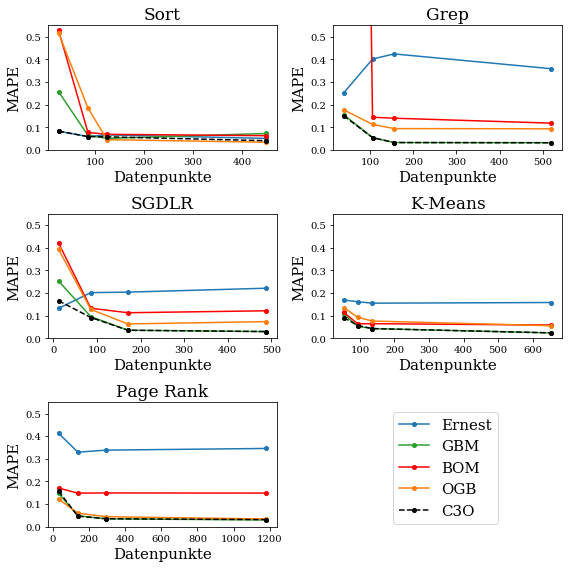

In [41]:
ff = 'DejaVu Sans'
ff = 'DejaVu Serif'
matplotlib.rc('font', family=ff)

model_names = list(map(lambda m:m.name, models))

colors = ['tab:blue', 'tab:green', 'red', 'tab:orange', 'black']

plt.figure(figsize=(8,8))
for i, job in enumerate(jobs):
    results = read_results(job.name)
    plt.subplot(3,2,i+1)
    plt.title(job.name, fontsize=17)
    for j, model_name in enumerate(model_names):
        y = results.loc[model_name][:]    
        x =  results.loc[model_name].keys()
        line = plt.plot(x, y, '--' if model_name=='C3O' else '-', label=model_name, color=colors[j], marker='o',
                       markersize=4)
        plt.xlabel('Datenpunkte', fontsize=15)
        plt.ylabel('MAPE', fontsize=15)
        
        plt.ylim(0, .55)

plt.figlegend(model_names, fontsize=15, loc='lower center', ncol=1, bbox_to_anchor=[0.78, +.07], 
              bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
plt.savefig('compression_dbscan.pdf', bbox_inches='tight')
plt.show()

### Display & Tracking Training-Time

In [37]:
import time
start_time = time.time()

create_new_compression_evaluations(amount=10)

# time tracking
with open('time_tracking.csv', 'at') as f:
   for job in jobs:
       for model in models:
           f.write(f"{job.name},{model.name},{grep_dp},{time.time() - start_time}\n")
print("--- %s seconds ---" % (time.time() - start_time))

In [50]:
def read_results_time_tracking(job_name):
    try: results = pd.read_csv('time_tracking.csv', header=None)
    except: return

    rres = [(job, model, ds, float(mape)) for job, model, ds, mape in results.values]
    df = pd.DataFrame(rres, columns = ('Job', 'Model', 'Compression', 'MAPE'))
    groups = df.groupby(by=['Job', 'Model', 'Compression'], as_index=False)
    #df = groups.mean()
    # Filter info for just the job we are interested in
    jobdf = df[df['Job'] == job_name].set_index(['Model', 'Compression'])
    # Remove redundant info
    return jobdf.unstack()['MAPE']

def display_job_evaluation(job_name):

    try: displaydf = read_results(job_name)
    except: display(HTML(f"<h3>{job_name}</h3> None")); return 
    
    # Style the output to highlight the important information
    def highlight_row_min(row):
        return ['color: black' if cell == min(row) else 'color: dimgray' for cell in row]
    
    def highlight_min(data, color='aquamarine', bold=False):
        # highlight the minimum in a Series or DataFrame
        attr1 = f"background-color: {color}"
        attr2 = f"font-weight: {'bold' if bold else 'normal'}"
        if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
            is_min = data == data.min()
            return [attr1 if v else '' for v in is_min]
        else:  # from .apply(axis=None)
            is_min = data == data.min().min()
            return pd.DataFrame(np.where(is_min, attr2, ''),
                                index=data.index, columns=data.columns)
        
    table_html = displaydf.style.apply(highlight_row_min,axis=1) \
                                .apply(highlight_min, axis=0, color='aquamarine') \
                                .apply(highlight_min, axis=None, bold=True) \
                                .format("{:.2%}") \
                                ._repr_html_()
    
    display(HTML(f"<h3>{job_name}</h3>" + table_html ))

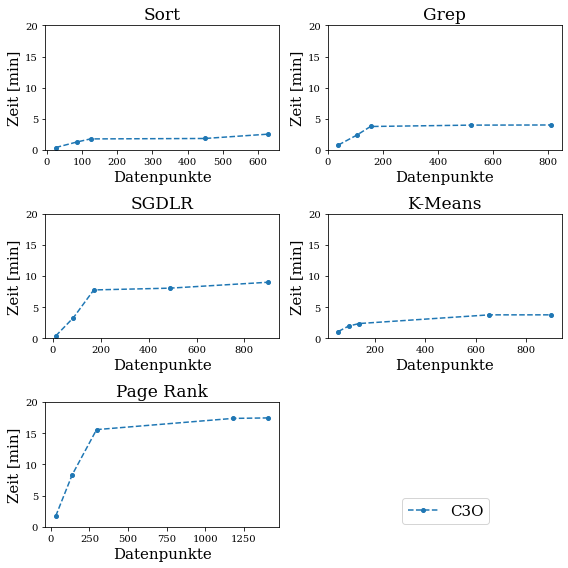

In [52]:
ff = 'DejaVu Sans'
ff = 'DejaVu Serif'
matplotlib.rc('font', family=ff)

model_names = list(map(lambda m:m.name, models))

colors = ['tab:blue', 'tab:green', 'red', 'tab:orange', 'black']

plt.figure(figsize=(8,8))
for i, job in enumerate(jobs):
    results = read_results_time_tracking(job.name)
    plt.subplot(3,2,i+1)
    plt.title(job.name, fontsize=17)
    for j, model_name in enumerate(model_names):
        y = results.loc[model_name][:]/60
        x =  results.loc[model_name].keys()
        line = plt.plot(x, y, '--' if model_name=='C3O' else '-', label=model_name, color=colors[j], marker='o',
                       markersize=4)
        plt.xlabel('Datenpunkte', fontsize=15)
        plt.ylabel('Zeit [min]', fontsize=15)
        
        plt.ylim(0, 20)

plt.figlegend(model_names, fontsize=15, loc='lower center', ncol=1, bbox_to_anchor=[0.78, +.07], 
              bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
plt.savefig('time_tracking.pdf', bbox_inches='tight')
plt.show()

## GET MAPE of all Jobs

In [49]:
for job in jobs:
    results = pd.read_csv('compression_results_dbscan (no noisy).csv', header=None)
    rres = [(job, model, ds, float(mape)) for job, model, ds, mape in results.values]
    df = pd.DataFrame(rres, columns = ('Job', 'Model', 'Compression', 'MAPE'))
    groups = df.groupby(by=['Job', 'Model', 'Compression'], as_index=False)
    df = groups.mean()
    # Filter info for just the job we are interested in
    jobdf = df[df['Job'] == job.name].set_index(['Model', 'Compression'])

c3oResults = df[df['Model'] == 'C3O'].iloc[::-1]
print(c3oResults)
with open('dbscan_vs_kmeans.csv', 'at') as f:
    for i in range(5):
        f.write(f"{'C3O-DBSCAN'},{i},{c3oResults.iloc[i::5, :].mean().values[1]}\n")
        #print(c3oResults.iloc[i::5, :].mean().values[1])

           Job Model  Compression      MAPE
109       Sort   C3O          630  0.056157
108       Sort   C3O          449  0.041160
107       Sort   C3O          124  0.058142
106       Sort   C3O           85  0.059279
105       Sort   C3O           25  0.083007
84       SGDLR   C3O          900  0.033490
83       SGDLR   C3O          488  0.030117
82       SGDLR   C3O          171  0.036024
81       SGDLR   C3O           86  0.092222
80       SGDLR   C3O           12  0.166322
59   Page Rank   C3O         1410  0.030367
58   Page Rank   C3O         1180  0.031706
57   Page Rank   C3O          296  0.035521
56   Page Rank   C3O          138  0.047105
55   Page Rank   C3O           31  0.157035
34     K-Means   C3O          900  0.026440
33     K-Means   C3O          654  0.024331
32     K-Means   C3O          136  0.043295
31     K-Means   C3O           94  0.056819
30     K-Means   C3O           53  0.091892
9         Grep   C3O          810  0.034603
8         Grep   C3O          52